## testing ways to visualize lasso gridsearch

Major take aways:
-- plot_lasso_grid_search: graphing what I want it to graph but the confidence interval around the line is unpleasant to look at
-- lasso_train_test_graph: graph looks better. but creates a situation where you are picking the alphas based on the test dataset so there is too much data leakage. But I also like the number of features graph under the test score graph

## Load packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import helper
style.use('fivethirtyeight')

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

## Load Data

In [3]:
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)


train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass'])



In [4]:
cat_feats = train.select_dtypes(['object','bool']).columns.to_list()



In [5]:
num_cols = train.select_dtypes(['float64','int64']).columns.to_list()
num_cols.remove('SalePrice')



## defining functions

In [19]:
def lasso_model_score(alpha, train_, test_, target, 
                             categorical_features,
                             drop_cols = ['SalePrice', 'TotalBsmtSF']):
    scaler = StandardScaler(with_mean=False)
    lasso = Lasso()
    
    
    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      categorical_features)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target])
    lasso = Lasso(alpha=alpha)
    selector = SelectFromModel(estimator=lasso)
    X = selector.fit_transform(X, y)
    
    lasso.fit(X,y)
    train_score = lasso.score(X,y)

    X_tst = test_.drop(drop_cols,axis=1)
    X_tst = transformer.transform(X_tst)
    X_tst = scaler.transform(X_tst)
    y_tst = np.log(test_[target])
    X_tst = selector.transform(X_tst)
    test_score = lasso.score(X_tst,y_tst)
    
    
    feat_names = transformer.get_feature_names()
    mask = selector.get_support()
    lasso_feats = [a for a, b in zip(feat_names, mask) if b]
    
    return train_score, test_score,lasso_feats

In [7]:
def plot_lasso_grid_search(
    alpha_start_, alpha_stop_, alpha_num_,
    train_, 
    test_,
    target_, 
    cat_feats_,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3
               ):
    # lasso regression model set up.
    scaler = StandardScaler(with_mean=False)
    lasso = Lasso()

    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      cat_feats_)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target_])

    # Grid Search set up.

    alphas = np.linspace(alpha_start_, alpha_stop_, alpha_num_)
    tuned_parameters = [{'alpha': alphas}]
    clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
    clf.fit(X, y)
    
    # graphing data set up
    grid_search_df = pd.DataFrame({
        'split0_test_score':clf.cv_results_['split0_test_score'],
        'split1_test_score':clf.cv_results_['split1_test_score'],
        'split2_test_score':clf.cv_results_['split2_test_score'],
        'mean_test_score':clf.cv_results_['mean_test_score'],
        'param_alpha':clf.cv_results_['param_alpha']
    })

    graph_df = pd.melt(
        grid_search_df,
        id_vars=['param_alpha'], 
        value_vars=['split0_test_score','split1_test_score','split2_test_score']
    )
    graph_df.columns = ['alphas','split_test','model_score']
    
    # graph
    sns.lineplot(data = graph_df,
                x = 'alphas', y = 'model_score',
    #             ax=axs[0]
                 color=colors[0]
                )
    plt.show()

In [8]:
def lasso_train_test_graph(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []
    lasso_feat_len = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
            lasso_feat_len.append(len(lasso_feats))
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)
            lasso_feat_len.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    lasso_feat_len = np.array(lasso_feat_len)
    #graph
    # construct df.
    lasso_alpha_scores = pd.DataFrame({"alphas":alphas,
                'train':lasso_scores_train,
                'test':lasso_scores_test,
                'feature_len':lasso_feat_len,                                       
                                      })
    # change df to graphable structure.
    graph_df = pd.melt(
        lasso_alpha_scores,
        id_vars=['alphas'], 
        value_vars=['train','test']
    )
    graph_df.columns = ['alphas','data_type','model_score']
    
    fig, axs = plt.subplots(2,1,figsize=(10,12))
    sns.lineplot(data = graph_df,
                x = 'alphas', y = 'model_score',hue = 'data_type',
                ax=axs[0]
                )
    # define variable for test train model that is the closest.
    lasso_alpha_scores['train_test_dist'] = abs(lasso_alpha_scores['train'] -
                                                lasso_alpha_scores['test'])
    shortest_dist = lasso_alpha_scores.sort_values('train_test_dist'
                                               ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = shortest_dist['alphas']
    best_lasso_train = shortest_dist['train']
    best_lasso_test = shortest_dist['test']
    best_lasso_dist = shortest_dist['train_test_dist']

    # construct clostest alpha line
    axs[0].plot([best_lasso_alpha,best_lasso_alpha], 
             [best_lasso_train,best_lasso_test],color=colors[2])
    axs[0].plot(best_lasso_alpha, best_lasso_train,
             marker='o', markersize=8,
             color=colors[2])
    axs[0].plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[2])
    # label closest alpha point
    axs[0].text(best_lasso_alpha +.0005, ((best_lasso_test+best_lasso_train)/2), 
             "Alpha = {:.5f}\nDistance = {:.5f}".format(best_lasso_alpha,best_lasso_dist))
    
    # define variable for the test model that has the best score
    
    test_max = lasso_alpha_scores.sort_values('test',ascending=False
                                             ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = test_max['alphas']
    best_lasso_test = test_max['test']

    axs[0].plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[3])
    axs[0].text(best_lasso_alpha +.0005, best_lasso_test, 
         "Alpha = {:.5f}\nScore = {:.3f}".format(best_lasso_alpha,best_lasso_test))
    
    
    

    axs[0].set_title(r'Lasso Train-Test $R^2$ Comparison')
    axs[0].set_xlabel(r'hyperparameter $\alpha$')
    axs[0].set_ylabel(r'$R^2$')
    
    axs[1].set_xlabel(r'hyperparameter $\alpha$')
    axs[1].set_ylabel(r'Number of Features')




    
    sns.lineplot(data = lasso_alpha_scores,
            x = 'alphas', y = 'feature_len',
                 color = colors[2],
            ax=axs[1]
            )
    plt.show()

#### Iteratively graphing the zooming in of the gridsearch into the section with the highest score.

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10364413607338552, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(


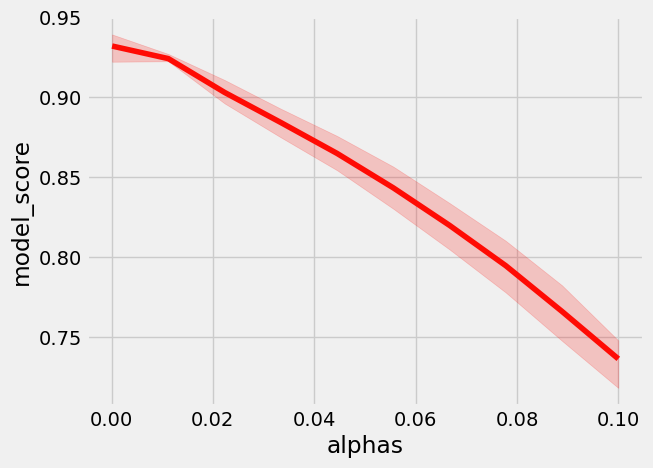

In [11]:
plot_lasso_grid_search(
    0.0001, .1, 10,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10364413607338552, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(


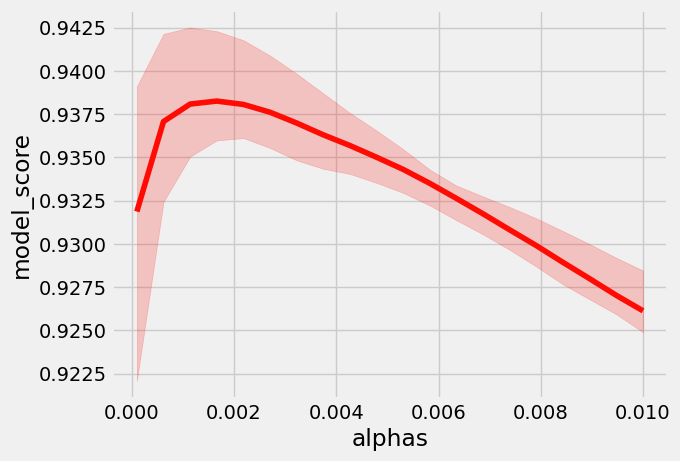

In [12]:
plot_lasso_grid_search(
    0.0001, .01, 20,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10364413607338552, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0668580193031092, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(


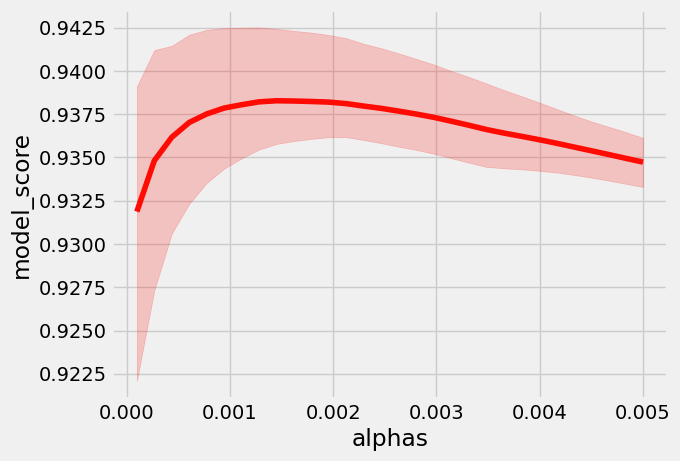

In [13]:
plot_lasso_grid_search(
    0.0001, .005, 30,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

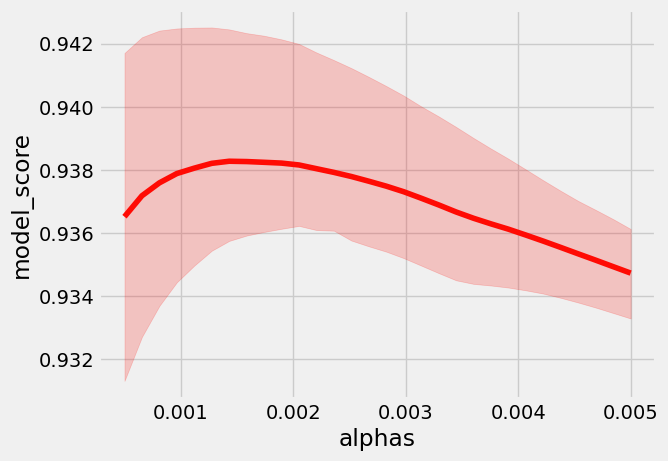

In [14]:
plot_lasso_grid_search(
    0.0005, .005, 30,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

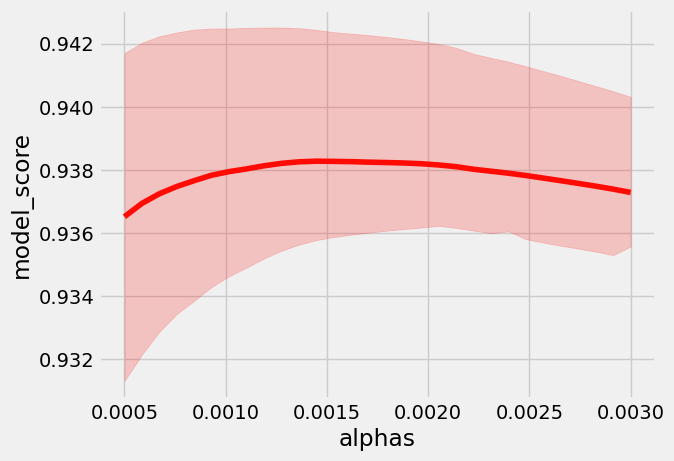

In [15]:
plot_lasso_grid_search(
    0.0005, .003, 30,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

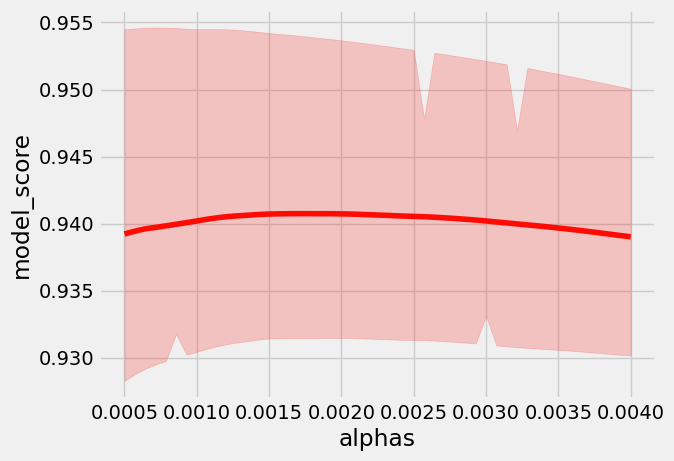

In [17]:
plot_lasso_grid_search(
    0.0005, .004, 50,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 5,
               )

#### train test graph

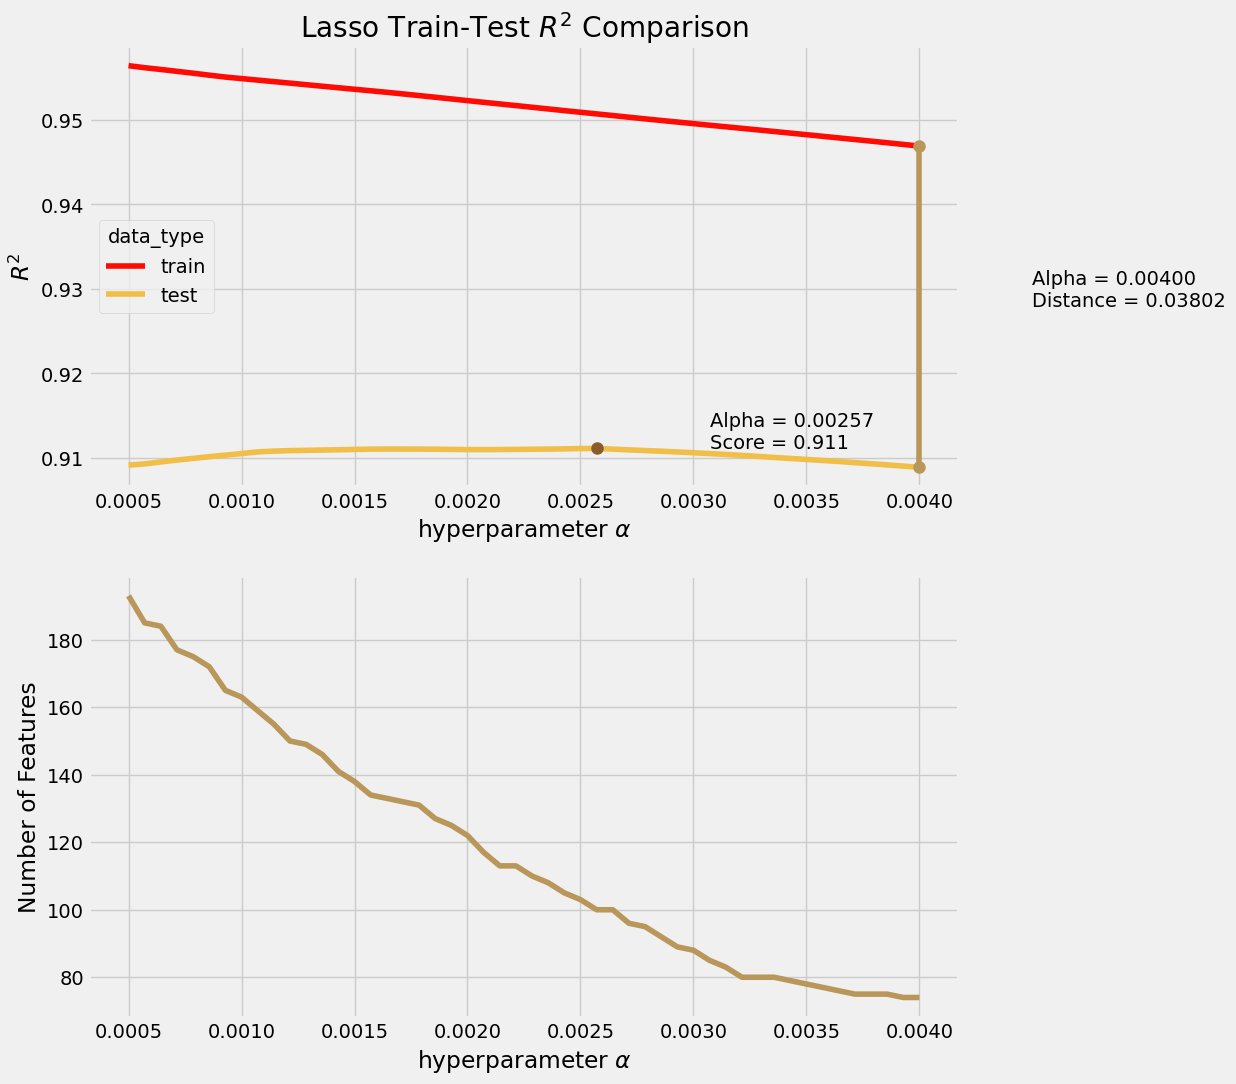

In [18]:
lasso_train_test_graph(0.0005, .004, 50,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
               )

#### check model at the parameters the graph suggests are worth investigating.

In [20]:
lasso_model_score(.00275,
                  train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.950226185648791,
 0.9109138178428278,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_30',
  'Cat__x0_90',
  'Cat__x1_C (all)',
  'Cat__x1_RH',
  'Cat__x1_RL',
  'Cat__x1_RM',
  'Cat__x2_Grvl',
  'Cat__x4_Bnk',
  'Cat__x6_CulDSac',
  'Cat__x6_FR2',
  'Cat__x8_BrDale',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_CollgCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_Greens',
  'Cat__x8_GrnHill',
  'Cat__x8_MeadowV',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x8_Veenker',
  'Cat__x9_Feedr',
  'Cat__x9_Norm',
  'Cat__x10_Feedr',
  'Cat__x11_1Fam',
  'Cat__x11_Twnhs',
  'Cat__x13_Flat',
  'Cat__x15_BrkComm',
  'Cat__x15_BrkFace',
  'Cat__x15_HdBoard',
  'Cat__x15_PreCast',
  'Cat__x16_AsbShng',
  'Cat__x16_CBlock',
  'Cat__x16_Plywood',
  'Cat__x16_VinylSd',
  'Cat__x16_Wd Shng',
  'Cat__x18_BrkTil',
  'Cat__x18_PConc',
  'Cat__x18_Wood',
  'Cat__x19_ALQ',
  'Cat__x19_GLQ',
  'Cat__x

In [21]:
lasso_model_score(.004,
                  train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.9469059001914502,
 0.9088902567995484,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_30',
  'Cat__x1_C (all)',
  'Cat__x1_RH',
  'Cat__x1_RM',
  'Cat__x4_Bnk',
  'Cat__x6_CulDSac',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_GrnHill',
  'Cat__x8_MeadowV',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x9_Feedr',
  'Cat__x9_Norm',
  'Cat__x11_1Fam',
  'Cat__x11_Twnhs',
  'Cat__x13_Flat',
  'Cat__x15_BrkComm',
  'Cat__x15_BrkFace',
  'Cat__x15_PreCast',
  'Cat__x16_AsbShng',
  'Cat__x16_CBlock',
  'Cat__x16_Wd Shng',
  'Cat__x18_BrkTil',
  'Cat__x18_PConc',
  'Cat__x19_ALQ',
  'Cat__x19_GLQ',
  'Cat__x19_LwQ',
  'Cat__x20_GLQ',
  'Cat__x22_N',
  'Cat__x24_Maj1',
  'Cat__x24_Maj2',
  'Cat__x24_Typ',
  'Cat__x25_Attchd',
  'Cat__x25_Basment',
  'Cat__x28_Con',
  'Cat__x29_Normal',
  'GrLivArea',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'Overall